# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [186]:
%matplotlib inline 
import warnings 
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd 
import numpy as  np 
import matplotlib.pyplot as plt 
import nltk 
import string
from  sklearn.feature_extraction.text import CountVectorizer
from  sklearn.feature_extraction.text import TfidfTransformer
from  sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt 
import seaborn as sns 
from  sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import string 
import re 
from  nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import word2vec
from gensim.models import keyedvectors
import pickle

from tqdm import tqdm
import os





In [5]:
## Reading Data

con=sqlite3.connect("database.sqlite")

In [10]:
df=pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""",con)

In [11]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [12]:
df.shape

(525814, 10)

In [14]:
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

- There are around 160.5K duplicate records and we drop them

In [19]:
df[df.duplicated(subset=["Time","UserId","Summary","Text"])]["Id"].count()

160521

In [22]:
df.drop_duplicates(subset=["Time","UserId","Summary","Text"],keep="last",inplace=True)

- Helpfulness numerator can not  be greater than denominnator 

In [35]:
#df=df[~(df.HelpfulnessNumerator>df.HelpfulnessDenominator)]
df[(df.HelpfulnessNumerator>df.HelpfulnessDenominator)].index
df.drop(index=df[(df.HelpfulnessNumerator>df.HelpfulnessDenominator)].index,inplace=True,axis=0)

- There two records which have Hepfullness numerator greater than denominator

In [36]:
df[(df.HelpfulnessNumerator>df.HelpfulnessDenominator)].index

Int64Index([], dtype='int64')

In [37]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
...,...,...,...,...,...,...,...,...,...,...
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [47]:
percentages=(df.groupby("Score")["Id"].count()/len(df)).round(2)*100

- There are around 69 percent of products rated 5 star rating 
- 15 percent rated 4 star ratings
- 10 percent rated 1 star 

(array([ 36516.,      0.,  20844.,      0.,      0.,      0.,      0.,
         56223.,      0., 251708.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

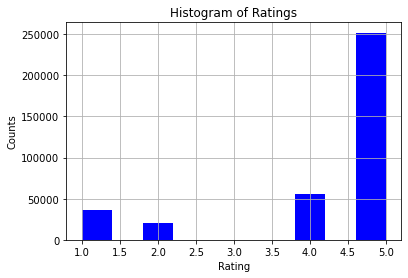

In [67]:
df["Score"].hist()
plt.xlabel("Rating")
plt.ylabel("Counts")
plt.title("Histogram of Ratings")
plt.hist(df["Score"],color="b",label="Rating")



## Text preprocessing 

In [88]:
# printing some random reviews
sent_0= df.Text[0]
print(sent_0)
print("=="*50)

sent_100= df.Text[100]
print(sent_100)
print("=="*50)


sent_1000= df.Text[1000]
print(sent_1000)
print("=="*50)

sent_1500= df.Text[1500]
print(sent_1500)
print("=="*50)



I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
I was diappointed in the flavor and texture of this mix.  I usually like most of the Low Carb things I have tried, but was diappointed in this specific one.
Gatorade G2 is the way to go when you want the benefits of Gatorade without quite so much sugar. As I am in a "pre-diabetes" state these days, I am drinking this type of Gatorade instead of the regular Gatorade which has noticeably more sugar in it. The really good thing is that this still replenishes carbs and electrolytes after I exercise without putting unnecessary extra sugar into my system.<br /><br />G2 comes in flavors including fruit punch and grape.<br /><br />If you're on the go, the advantage of these bottles of Gatorade is this: because the bottles are smaller 

- We can see that our data consists of punctuations and HTML tags

# Removing URLs from the text

In [89]:
#Define the text from which you want to replace the url with "".
text ='''The link to this post is https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python'''
re.sub(r"http\S+", "", text)
sent_0=re.sub(r"http\S+", "", sent_0)
sent_100=re.sub(r"http\S+", "", sent_100)
sent_1000=re.sub(r"http\S+", "", sent_1000)
sent_1500=re.sub(r"http\S+", "", sent_1500)

In [92]:
print(sent_1000)

Gatorade G2 is the way to go when you want the benefits of Gatorade without quite so much sugar. As I am in a "pre-diabetes" state these days, I am drinking this type of Gatorade instead of the regular Gatorade which has noticeably more sugar in it. The really good thing is that this still replenishes carbs and electrolytes after I exercise without putting unnecessary extra sugar into my system.<br /><br />G2 comes in flavors including fruit punch and grape.<br /><br />If you're on the go, the advantage of these bottles of Gatorade is this: because the bottles are smaller you can carry them with you much easier than if you took the regular, larger size bottles of Gatorade G2.<br /><br />I highly recommend this drink if you need extra carbs or electrolytes after exercising; it replenishes them very well without the extra sugar found in regular Gatorade.


# Extracting text from HTML and XML data using beautiful soup

In [95]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_100, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)



Gatorade G2 is the way to go when you want the benefits of Gatorade without quite so much sugar. As I am in a "pre-diabetes" state these days, I am drinking this type of Gatorade instead of the regular Gatorade which has noticeably more sugar in it. The really good thing is that this still replenishes carbs and electrolytes after I exercise without putting unnecessary extra sugar into my system.G2 comes in flavors including fruit punch and grape.If you're on the go, the advantage of these bottles of Gatorade is this: because the bottles are smaller you can carry them with you much easier than if you took the regular, larger size bottles of Gatorade G2.I highly recommend this drink if you need extra carbs or electrolytes after exercising; it replenishes them very well without the extra sugar found in regular Gatorade.
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and 

- Here you can see that HTML tags are removed from sent_1000
- Also we can see in data 

- You can see that Text contains won't and it should be considered as Will not 
- We should remove some specific notations of english 

In [104]:
df[df["Text"].str.contains("won't")].Text

22        I can remember buying this candy as a kid and ...
35        McCann's Instant Irish Oatmeal, Variety Pack o...
70        These looked like a perfect snack to through i...
77        My dog has a ton of allergies both environment...
186       The tiny Altoids are great for a quick breath ...
                                ...                        
525599    One word 'Yum yum yum'. OK 3 words 'cause it i...
525627    I bought them at Shoprite (at 3.79 for a box o...
525632    I have been using stevia for over a decade and...
525730    This is my husbands favorite tea.  He won't dr...
525742    Grab some flavor and save yourself some chemic...
Name: Text, Length: 10280, dtype: object

In [108]:
df[df["Text"].str.contains("'ve")].Text

12        My cats have been happily eating Felidae Plati...
20        My husband is a Twizzlers addict.  We've bough...
28        I got this for my Mum who is not diabetic but ...
34        Instant oatmeal can become soggy the minute th...
50        I roast at home with a stove-top popcorn poppe...
                                ...                        
525744    Notice that this taco seasoning packet weighs ...
525765    If you want to add a hint of Meyer lemon flavo...
525773    When we brought home two 3-month-old purebred ...
525784    I've tried several violet flavored candies in ...
525794    This soup is mostly broth. Although it has a k...
Name: Text, Length: 43207, dtype: object

In [113]:
re.sub(r"won't", "will not", df["Text"][0])
re.sub(r"can't", "can not", df["Text"][0])
re.sub(r"can't", "can not", df["Text"][0])
re.sub(r"can't", "can not", df["Text"][0])

re.sub(r"can't", "can not", df["Text"][0])



'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [115]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    # Remove words with digits
    re.sub("\S*\d\S*", "", phrase)
    
    return phrase

In [117]:
df["Text"]=df["Text"].apply(decontracted)

In [118]:
re.sub("\S*\d\S*", "", sent_0)

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [119]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [127]:
df[df["Text"].str.contains("\S*\d\S*")].Text  ## gives us the words with digits 

18        Twizzlers, Strawberry my childhood favorite ca...
21        I bought these for my husband who is currently...
24        I have lived out of the US for over 7 yrs now,...
25        Product received is as advertised.<br /><br />...
34        Instant oatmeal can become soggy the minute th...
                                ...                        
525795    It is mostly broth, with the advertised 3/4 cu...
525800    Indie Candy is gummies are absolutely deliciou...
525804    As a foodie, I use a lot of Chinese 5 Spice po...
525808    My only complaint is that there is so much of ...
525811    These stars are small, so you can give 10-15 o...
Name: Text, Length: 125794, dtype: object

## Running all  steps together 

In [142]:
from tqdm import tqdm 
preprocessed_reviews=[]

for sentence in tqdm(df["Text"].values):
    ## removing URL from text 
    sentence=re.sub(r"http\S+","",sentence)
    ##  removing HTML tags from text
    sentence=BeautifulSoup(sentence,"lxml").get_text()
    
    ## removing decontracted words
    sentence=decontracted(sentence)
    
    ## removing words with digits 
    
    sentence=re.sub(r"\S*\d\S*","",sentence)
    
    ## removing words  with other than characters  like removing punctuations and special characters
    
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    out=" ".join([ e.lower().strip() for e in  sentence.split(" ") if e.lower() not in stopwords])
    preprocessed_reviews.append(out)
    

100%|████████████████████████████████████████████████████████████████████████| 365291/365291 [01:29<00:00, 4089.05it/s]


In [141]:
" ".join(preprocessed_reviews[1500])

'brands like always enjoyed really good bargain sale '

In [138]:
out

['satisfied',
 'product',
 'advertised',
 'use',
 'cereal',
 'raw',
 'vinegar',
 'general',
 'sweetner',
 '']

In [147]:
preprocessed_reviews[23000]

'cats really love food recommend anyone know cat throws lot many times stop throwing altogether put food great sensitive tummies like fact comes multiple smaller pouches stays extra fresh easier handle back joint problems not handle large bags food willing pay extra convenience plus like knowing kitties fresh food cat allergic many ingredients super premium holistic food brands none cats eat dark colored cat foods like anyway knew color food would hit realize corn not see difference expensive brands use potatoes blueberries tomatoes cranberries etc cats not meant eat either anyway happy food cats vet says perfectly fine feed happy '

## Word cloud 

In [159]:
from wordcloud import WordCloud


In [163]:
df["Text"].values[1]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

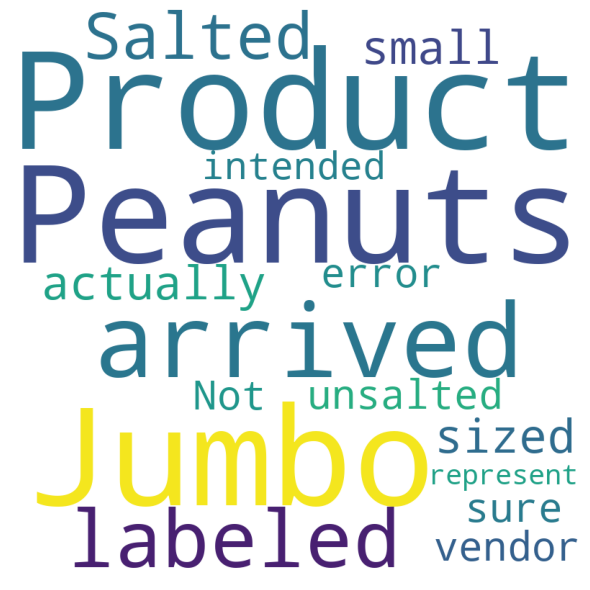

In [162]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df["Text"].values[1])
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Bag of Words 

In [149]:
count_vect = CountVectorizer()
count_vect.fit(preprocessed_reviews)  # we generally fit on train data 
print("Some feature names", count_vect.get_feature_names()[:200])

Some feature names ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa']


In [154]:
## transform on test data
final_counts = count_vect.transform(preprocessed_reviews)
print(" type of the object",type(final_counts))
print("shape of the dataframe after transforming",final_counts.get_shape())
print("No of unique words",final_counts.get_shape()[1])



 type of the object <class 'scipy.sparse.csr.csr_matrix'>
shape of the dataframe after transforming (365291, 116756)
No of unique words 116756


- Bag of  words creates sparse vectors which is most of the values 0's and only few values are 1
- Bag  of words does not consider semantic meaning into consideration 
- The difference between two bag of word vectors  is no of disimilar words that exist among two. It just finds no of words that are dissimilar
- vectors that have more common words in the respective  sentences considered to be closure and if the diff between two vectors is too high then they are said to be  disimilar sentences.
- Bag of words is the simplest way to generate vectors from sentences

## Bi-grams and n-Grams.

In [165]:
Bigram=CountVectorizer(ngram_range=(1,2),min_df=10,max_features=15000)
Bigram.fit(preprocessed_reviews)
Bigram.get_feature_names()[0:100]
final_counts=Bigram.fit_transform(preprocessed_reviews)
print("type of the data frame",type(final_counts))
print("shape of the data frame",final_counts.get_shape())

print("no of unique words ",final_counts.get_shape()[1])


type of the data frame <class 'scipy.sparse.csr.csr_matrix'>
shape of the data frame (365291, 1000)


In [166]:
print("no of unique words ",final_counts.get_shape()[1])

no of unique words  1000


In [167]:
Bigram.get_feature_names()[900:1000]

['thought would',
 'three',
 'throw',
 'time',
 'times',
 'tiny',
 'today',
 'together',
 'told',
 'tomato',
 'took',
 'top',
 'total',
 'totally',
 'touch',
 'toy',
 'traditional',
 'treat',
 'treats',
 'tried',
 'true',
 'truly',
 'try',
 'trying',
 'tuna',
 'turn',
 'turned',
 'twice',
 'two',
 'type',
 'types',
 'unfortunately',
 'unless',
 'unlike',
 'us',
 'use',
 'used',
 'uses',
 'using',
 'usual',
 'usually',
 'value',
 'vanilla',
 'varieties',
 'variety',
 'vegan',
 'vegetables',
 'veggies',
 'version',
 'vet',
 'vinegar',
 'vitamin',
 'vitamins',
 'wait',
 'want',
 'wanted',
 'warm',
 'waste',
 'water',
 'way',
 'weak',
 'website',
 'week',
 'weeks',
 'weight',
 'well',
 'went',
 'wet',
 'whatever',
 'wheat',
 'white',
 'whole',
 'wife',
 'wine',
 'wish',
 'within',
 'without',
 'wonderful',
 'work',
 'worked',
 'works',
 'world',
 'worth',
 'would',
 'would buy',
 'would like',
 'would not',
 'would recommend',
 'wow',
 'wrapped',
 'wrong',
 'year',
 'year old',
 'years',
 

- The disadvantage of Bag of words is it does not consider the sequence info for example 

The pasta is tasty and affordable 

The pasta is not tasty and not affordable 

- if you remove stop words then both the vector will be eactly same and zero distance. This is somehow can be addressed using Bigrams Trigram and n gram.

- (The Pasta),(Pasta is) ,(is  tasty ) ...
-(The Pasta),(Pasta is),(not tasty) 

- Here, above vectors will not be same and they have some flexibilty to differentiate between above two vectors. Bi-grams presevers some sequence info which can differentiate between two sentences.

- The disadvantage of the Bi-grams and Tri-gram and n-gram is they *increased the dimensions of the vector massively * and this leads to high training time.

- Another disadvantage is it does not capture semantic meaning


## TF-IDF Vectorisation

In [170]:
vec=TfidfVectorizer(ngram_range=(1,2),max_features=20000,min_df=15)
vec.fit(preprocessed_reviews)
print(vec.get_feature_names()[10])

tfcounts=vec.fit_transform(preprocessed_reviews)
print("type of the data",type(tfcounts))
print("Shape of the data",tfcounts.get_shape())
print("unique words",tfcounts.get_shape()[1])

able order
type of the data <class 'scipy.sparse.csr.csr_matrix'>
Shape of the data (365291, 20000)
unique words 20000


- Term frequency is the probability of a word appearing in the document

(No of times a word appears in document/Total no of words)

- IDF(Wi, Document corpus)

log(Total documents in corpus/No of documents that contain word)

This technique is a normalized technique and it gives less weight to a word that appears more frequently in corpus 

and more importance to the word appear more frequently in document.


if word appears more frequently in docuemnt corpus then IDF will be less (N/ni) as ni increase IDF decreases 

if word appears more frequently in docuemnt  then TF  will be more (No of times a word appear/Total no of words in document)

- The disadvantge of IDF is again it does not capture semantic meaning and this issue will be solved if you use the technique called Word2vec 


## Word2VEC Google

In [175]:
import os
print(os.path.isfile('GoogleNews-vectors-negative300.bin'))
if os.path.isfile('GoogleNews-vectors-negative300.bin'):
    w2v_model=keyedvectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary=True)
    print(w2v_model.wv.most_similar('great'))
    print(w2v_model.wv.most_similar('worst'))

True


AttributeError: 'KeyedVectors' object has no attribute 'wv'

In [177]:
print(w2v_model.most_similar('great'))
print(w2v_model.most_similar('worst'))

[('terrific', 0.7989331483840942), ('fantastic', 0.7935212254524231), ('tremendous', 0.7748857140541077), ('wonderful', 0.7647868990898132), ('good', 0.7291510105133057), ('incredible', 0.7032874226570129), ('marvelous', 0.6971103549003601), ('phenomenal', 0.6841564178466797), ('amazing', 0.6634128093719482), ('awesome', 0.6510506272315979)]
[('Worst', 0.6146092414855957), ('weakest', 0.6143775582313538), ('scariest', 0.5957257747650146), ('ugliest', 0.5931181311607361), ('best', 0.5835110545158386), ('bleakest', 0.5718506574630737), ('strongest', 0.5671455264091492), ('nastiest', 0.5644308924674988), ('lousiest', 0.5631450414657593), ('toughest', 0.5624396204948425)]


In [178]:
w2v_model["great"]

array([ 7.17773438e-02,  2.08007812e-01, -2.84423828e-02,  1.78710938e-01,
        1.32812500e-01, -9.96093750e-02,  9.61914062e-02, -1.16699219e-01,
       -8.54492188e-03,  1.48437500e-01, -3.34472656e-02, -1.85546875e-01,
        4.10156250e-02, -8.98437500e-02,  2.17285156e-02,  6.93359375e-02,
        1.80664062e-01,  2.22656250e-01, -1.00585938e-01, -6.93359375e-02,
        1.04427338e-04,  1.60156250e-01,  4.07714844e-02,  7.37304688e-02,
        1.53320312e-01,  6.78710938e-02, -1.03027344e-01,  4.17480469e-02,
        4.27246094e-02, -1.10351562e-01, -6.68945312e-02,  4.19921875e-02,
        2.50000000e-01,  2.12890625e-01,  1.59179688e-01,  1.44653320e-02,
       -4.88281250e-02,  1.39770508e-02,  3.55529785e-03,  2.09960938e-01,
        1.52343750e-01, -7.32421875e-02,  2.16796875e-01, -5.76171875e-02,
       -2.84423828e-02, -3.60107422e-03,  1.52343750e-01, -2.63671875e-02,
        2.13623047e-02, -1.51367188e-01,  1.04003906e-01,  3.18359375e-01,
       -1.85546875e-01,  

In [179]:
w2v_model["worst"]

array([ 1.66015625e-01, -8.20312500e-02,  4.51171875e-01,  1.22558594e-01,
        1.34765625e-01,  1.33789062e-01, -3.88671875e-01, -3.66210938e-02,
        5.15625000e-01,  1.04003906e-01,  1.82617188e-01, -1.66015625e-01,
        2.00195312e-01,  2.12890625e-01, -1.90429688e-02,  8.74023438e-02,
       -7.75146484e-03, -2.87109375e-01, -1.54296875e-01, -3.86718750e-01,
        2.15820312e-01,  2.04101562e-01, -3.14453125e-01, -4.00390625e-01,
        2.57812500e-01,  3.17382812e-02,  5.73730469e-03,  1.16699219e-01,
        2.20703125e-01,  1.01074219e-01, -1.53320312e-01, -3.83300781e-02,
        1.38549805e-02,  9.22851562e-02, -1.68457031e-02,  2.27539062e-01,
        1.07421875e-01, -2.43164062e-01, -9.81445312e-02,  3.49609375e-01,
        1.97265625e-01, -1.80664062e-01, -4.27246094e-02, -2.09960938e-01,
        1.14257812e-01,  4.37500000e-01,  1.00585938e-01,  5.22460938e-02,
       -1.41601562e-02,  1.16210938e-01,  1.32446289e-02,  2.73437500e-01,
       -1.41906738e-03,  

- We can see that word2vec is a dense vector 

## Custom Word2vec training

In [182]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_words=[]
for sentance in preprocessed_reviews:
    list_of_words.append(sentance.split())

In [193]:
from gensim.models import Word2Vec

w2v_model=Word2Vec(list_of_words,min_count=5,vector_size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('fantastic', 0.8800665736198425), ('terrific', 0.8773396611213684), ('awesome', 0.8621045351028442), ('good', 0.8613718748092651), ('excellent', 0.8393076658248901), ('wonderful', 0.818760871887207), ('perfect', 0.7724720239639282), ('nice', 0.7549582123756409), ('fabulous', 0.7432035803794861), ('amazing', 0.739490270614624)]
[('nastiest', 0.8716344833374023), ('greatest', 0.8063624501228333), ('disgusting', 0.7552257180213928), ('terrible', 0.7292175889015198), ('best', 0.7257232666015625), ('horrible', 0.7136186361312866), ('horrid', 0.7061728835105896), ('awful', 0.6961885094642639), ('nicest', 0.6930181384086609), ('worse', 0.6676079630851746)]


In [230]:
w2v_model.wv.get_vector("great")

array([-0.34833756, -2.1252453 , -3.4348078 ,  0.84897727,  2.4418142 ,
        0.7650669 , -1.590501  , -4.6415963 ,  0.96735543,  2.4516706 ,
       -0.5343169 ,  3.0419712 ,  0.2637764 ,  2.1512978 ,  0.6467275 ,
        0.5680243 ,  1.2850652 ,  0.32787   ,  2.6986172 ,  1.2850732 ,
       -0.49178278, -2.8930287 , -0.13398947, -1.0368295 ,  0.7751031 ,
       -2.0712013 , -1.8995773 ,  1.8723885 ,  4.165283  , -1.6723617 ,
        2.434656  , -3.6902914 ,  0.71731645, -1.5986097 ,  2.1965308 ,
        0.44792765,  2.1478322 , -0.4405682 , -1.0141021 ,  2.8258653 ,
        0.44953266,  1.4343351 , -1.6952077 , -0.8331893 ,  0.57797474,
        0.928305  ,  0.9153708 , -0.54725844, -2.8924801 , -0.7609833 ],
      dtype=float32)

In [ ]:
## Average word2vec

In [232]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_words): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_model.wv:
            vec = w2v_model.wv.get_vector(word)
            sent_vec += vec # Here you are adding values and later you are divinding 
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████| 365291/365291 [00:45<00:00, 7996.55it/s]

365291
50


In [233]:
sent_vectors

[array([-0.3861843 , -0.86441664,  0.69239821,  0.00395102,  1.25392529,
         0.42152367, -0.75666345, -0.93233336,  0.63955051,  0.12739596,
         0.35777394,  0.52413366, -0.90735078,  0.67476428,  0.79115043,
         0.33200713,  0.22721147,  0.1385683 ,  1.34149607,  0.64279142,
         1.37654805,  0.39999526, -1.37082534, -1.00116783, -0.99453987,
        -0.51873413,  0.48089765,  0.60315549, -0.67359875, -0.55482738,
        -0.38750153, -1.13516518, -1.36419637,  0.52310556, -0.01208249,
        -0.56694437, -0.19029348,  0.22825329, -0.71181086,  0.83573953,
         0.26340715,  0.53903124,  0.50534603,  0.28086192,  0.84640545,
        -0.4972659 ,  0.1472459 ,  0.48463183,  0.17807152, -0.73441793]),
 array([ 0.22961054, -0.18702141,  0.58294523,  0.63724734,  0.9849378 ,
         0.05821649, -0.31967854, -0.20718942,  0.67251182,  1.58284691,
         0.84508631,  0.44960835,  0.01327271, -1.00323009, -0.07908849,
         0.90028972, -0.58327489,  0.37716321,  1